In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
# from gym import spaces
from gymnasium import spaces
from scipy.optimize import root


from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from scipy.signal import convolve2d

In [2]:
import warnings

In [3]:
warnings.filterwarnings("error")

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 

In [4]:
x0, y0 = 8, 8

In [5]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(iA_star, iAe, TH, width=y0, height=x0,  density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    for it in iA_star:
        normals[0, it, x] = 1
        normals[0, it, y] = 1
    
    forces = np.zeros((width + 1, height + 1, 2))
    for it in iAe:
        forces[-1, it, x] = TH
    return normals, forces, density

In [6]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [7]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [8]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [9]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [10]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [11]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [12]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [13]:
class Model:
    def __init__(self, x):
        self.flag_ = True
#         self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [14]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [15]:
def calculate_smoothness_metric(binary_matrix):
    """
    Calculates a smoothness metric for a 2D binary matrix.
    Lower values indicate greater smoothness. A value of 0 means 
    the image is perfectly uniform or has only linear transitions.

    The metric is the sum of differences between a pixel and its
    right and bottom neighbors, effectively counting vertical and
    horizontal edges.

    Args:
        binary_matrix (list of lists or numpy array): A 2D matrix 
                                                     with values 0 or 1.

    Returns:
        int: The total count of horizontal and vertical transitions.
    """
    # Convert to a numpy array for efficient processing
    matrix = np.array(binary_matrix, dtype=int)
    h, w = matrix.shape
    
    # Calculate absolute differences for horizontal transitions
    # We slice the matrix to compare each element with its right neighbor
    horizontal_diffs = np.abs(matrix[:, :w-1] - matrix[:, 1:])
    
    # Calculate absolute differences for vertical transitions
    # We slice the matrix to compare each element with its bottom neighbor
    vertical_diffs = np.abs(matrix[:h-1, :] - matrix[1:, :])
    
    # The sum of these differences gives the total number of transitions (edges)
    total_transitions = np.sum(horizontal_diffs) + np.sum(vertical_diffs)
    
    return int(total_transitions)

In [16]:
def count_islands_dfs(grid):
    """
    Calculates the number of islands in a 2D binary grid using Depth First Search (DFS).

    An island is formed by connected 1's (horizontally/vertically adjacent).
    
    Args:
        grid (list of lists): A 2D matrix with values 0 or 1.

    Returns:
        int: The total number of islands found.
    """
#     if not grid or not grid[0]:
#         return 0
    
    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    island_count = 0

    def dfs(r, c):
        """Helper function to traverse and mark a single island as visited."""
        # Check boundary conditions and if the cell has already been visited or is water (0)
        if r < 0 or r >= rows or c < 0 or c >= cols or grid[r][c] == 0 or (r, c) in visited:
            return
        
        visited.add((r, c))
        
        # Recursively visit all adjacent cells (up, down, left, right)
        dfs(r + 1, c) # Down
        dfs(r - 1, c) # Up
        dfs(r, c + 1) # Right
        dfs(r, c - 1) # Left

    # Iterate through every cell in the grid
    for r in range(rows):
        for c in range(cols):
            # If we find land (1) that hasn't been visited yet, 
            # it means we've found the start of a new island.
            if grid[r][c] == 1 and (r, c) not in visited:
                island_count += 1
                # Start DFS from this point to mark all parts of this island
                dfs(r, c)
                
    return island_count

In [17]:
def count_nonzeroz(matrix_np, col):
    """
    Counts the number of non-zero elements in the  column of a NumPy array.
    """
    idx=[]
    count=0
    for i in range(len(matrix_np[:, col])):
        if matrix_np[i, col]==1.:
            idx.append(i)
            count+=1
    return idx, count

In [18]:
matrix_np=np.array([[1,0,0,1e-04],
                   [1,0,0,1],
                   [1,0,0,1],
                  [1,0,0,1e-04]])

In [19]:
iA_star=count_nonzeroz(matrix_np, 0)

In [20]:
iAe=count_nonzeroz(matrix_np, -1)

In [21]:
iAe

([1, 2], 2)

In [22]:
def check_pyramid_step(matrix):
    column_counts = [sum(col) for col in zip(*matrix)]
    
    # Check if first col is 1 and each next is exactly previous + 2
    for i in range(len(column_counts)):
        expected = 1 + (i * 2)
        if column_counts[i] != expected:
            return False
    return True

In [23]:
def is_valid_increasing_and_centered(matrix):
    arr = np.array(matrix)
    rows, cols = arr.shape
    
    # 1. Calculate column sums
    col_sums = arr.sum(axis=0)
    
    # 2. Check: Strictly increasing (never decreasing, never equal)
    if not np.all(np.diff(col_sums) > 0):
        return False
    
    # 3. Check: 1s must be centered vertically and contiguous
    for c in range(cols):
        column = arr[:, c]
        ones_indices = np.where(column == 1)[0]
        
        if len(ones_indices) > 0:
            # Check for continuity (no 0s between 1s)
            if ones_indices[-1] - ones_indices[0] + 1 != len(ones_indices):
                return False
            
            # Check for vertical centering
            # The midpoint of the 1s should be near the midpoint of the column
            col_mid = (rows - 1) / 2
            ones_mid = (ones_indices[0] + ones_indices[-1]) / 2
            if abs(col_mid - ones_mid) > 0.5: # 0.5 allows for odd/even height alignment
                return False
                
    return True

In [24]:
def calculate_pyramid_score(matrix):
    arr = np.array(matrix)
    rows, cols = arr.shape
    col_sums = arr.sum(axis=0)
    
    # 1. Monotonicity Check (Strictly Increasing)
    # If any column does not increase, the base score is 0.
    is_increasing = np.all(np.diff(col_sums) > 0)
    if not is_increasing:
        return 0.0

    # 2. Centering & Contiguity Score
    # We calculate how centered the 1s are in each column.
    centering_penalties = []
    col_mid = (rows - 1) / 2
    
    for c in range(cols):
        ones_indices = np.where(arr[:, c] == 1)[0]
        if len(ones_indices) == 0:
            continue
            
        # Contiguity Check: Are 1s in a solid block?
        is_contiguous = (ones_indices[-1] - ones_indices[0] + 1) == len(ones_indices)
        if not is_contiguous:
            centering_penalties.append(1.0) # Maximum penalty for gaps
            continue

        # Centering Check: Distance from column midpoint
        actual_mid = (ones_indices[0] + ones_indices[-1]) / 2
        dist = abs(col_mid - actual_mid)
        # Normalize penalty: 0 if perfectly centered, 1 if at the very edge
        centering_penalties.append(dist / col_mid if col_mid > 0 else 0)

    # Final Score: 100 - (Average Penalty * 100)
    final_score = (1 - np.mean(centering_penalties))
    return round(final_score, 2)

In [25]:
def get_sensitive_pyramid_score(matrix):
    arr = np.array(matrix, dtype=float)
    rows, cols = arr.shape
    col_sums = np.sum(arr, axis=0)
    
    # 1. Growth Sensitivity (0-40 points)
    # Penalizes non-increasing columns or "flat" growth.
    diffs = np.diff(col_sums)
    if np.any(diffs <= 0):
        growth_score = 0
    else:
        # Higher score if growth is consistent and positive
        growth_score = 40 * (1 - (1 / np.mean(diffs)))
    
    # 2. Centering & Symmetry Sensitivity (0-60 points)
    centering_scores = []
    y_mid = (rows - 1) / 2.0
    
    for c in range(cols):
        y_indices = np.where(arr[:, c] == 1)[0]
        if len(y_indices) == 0:
            continue
            
        # Center of Mass: average position of all 1s in this column
        center_of_mass = np.mean(y_indices)
        
        # Dispersion: How spread out are the 1s?
        # A perfectly centered column has mean == y_mid
        dist_from_center = abs(center_of_mass - y_mid)
        
        # Max possible distance is y_mid (from center to very top/bottom)
        # We use a non-linear penalty (squared) to be extra sensitive to small offsets
        column_penalty = (dist_from_center / y_mid) ** 2 if y_mid > 0 else 0
        centering_scores.append(1 - column_penalty)

    final_centering_score = 60 * np.mean(centering_scores) if centering_scores else 0
    
    return round(growth_score + final_centering_score, 2)/100

In [26]:
# mbb_beam(iA_star, iAe, TH=30)

In [27]:
def mass_flow_rate(A_star, pt=20, Tt=3500, gamma=1.4, R=350):
    return A_star*pt/np.sqrt(Tt)*np.sqrt(gamma/R)*((gamma+1)/2)**(-(gamma+1)/(2*(gamma-1)))

In [28]:
def mach(A, A_star, gamma=1.4, M_bc=0.1):
    def fun(M, A_=A, A_star_=A_star,gamma_=gamma):
        return (A_/A_star_)**2-1/M**2*(2/(gamma_+1)*(1+(gamma_-1)/2*M**2))**((gamma_+1)/(gamma_-1))
    sol = root(fun, M_bc)
    return sol.x[0]

In [29]:
def temperature(M, Tt=3500, gamma=1.4):
    return Tt*(1+(gamma-1)/2*M**2)**(-1)

In [30]:
def pressure(M, pt=20, gamma=1.4):
    return pt*(1+(gamma-1)/2*M**2)**(-gamma/(gamma-1))

In [31]:
def thrust(A_star, Ae, pt=20, Tt=3500, gamma=1.4, M_bc2=2, R=350, p0=0.101325):
    dm = mass_flow_rate(A_star, pt, Tt, gamma, R)
    Me=mach(Ae, A_star, gamma, M_bc=M_bc2)
    pe=pressure(Me, pt, gamma)
    Te=temperature(Me, Tt, gamma)
    Ve=Me*np.sqrt(gamma*R*Te)
    return dm*Ve+(pe-p0)*Ae

In [32]:
def symmetry_score_difference(vec):
    """
    Calculates the average absolute difference from perfect symmetry.
    Score of 0 means perfect symmetry.
    """
#     vec = np.asarray(vec)
    vec = np.asarray(vec).astype(int) # Ensure it is a numpy array
    reversed_vec = vec[::-1]
    
    # Calculate the absolute difference between corresponding elements
    differences = np.abs(vec - reversed_vec)
    
    # Return the average difference as the score
    score = np.mean(differences)
    
    return score

In [33]:
def matrix_symmetry_score_difference(matrix, axis=0):
    """
    Calculates the average absolute difference from perfect symmetry along an axis.
    
    Args:
        matrix (np.ndarray): The input 2D matrix.
        axis (int): 0 for horizontal symmetry (around X axis), 
                    1 for vertical symmetry (around Y axis).
                    
    Returns:
        float: Score of 0 means perfect symmetry.
    """
    matrix = np.asarray(matrix)
    
    if axis == 0:
        # Flip vertically (up-down) for horizontal symmetry check
        flipped_matrix = np.flipud(matrix)
    elif axis == 1:
        # Flip horizontally (left-right) for vertical symmetry check
        flipped_matrix = np.fliplr(matrix)
    else:
        raise ValueError("Axis must be 0 (horizontal) or 1 (vertical).")

    # Calculate the absolute difference between the original and mirrored matrix
    differences = np.abs(matrix - flipped_matrix)
    
    # Return the average difference as the score
    score = np.mean(differences)
    
    return score

In [34]:
matrix_np=np.array([[1e-04,1e-04,1,1,1],
                    [1e-04,1,1,1,1],
                    [1,1,1,1,1],
                    [1e-04,1,1,1,1],
                    [1e-04,1e-04,1,1,1]])

In [35]:
matrix_np=np.array([[1e-04,1e-04,1e-04,1e-04,1e-04],
                    [1e-04,1e-04,1e-04,1e-04,1e-04],
                    [1e-04,1e-04,1e-04,1e-04,1e-04],
                    [1e-04,1e-04,1e-04,1e-04,1e-04],
                    [1e-04,1e-04,1e-04,1e-04,1e-04]])

In [36]:
matrix_symmetry_score_difference(matrix_np)

0.0

In [37]:
def replace(obs):
    obs=obs.copy()
    for i in range(obs.shape[0]):
        for j in range(obs.shape[1]):
            if obs[i][j]==1e-04:
                obs[i][j]=0
            else:
                obs[i][j]=1
    return obs            

In [38]:
# symmetry_score_difference([0.1,1,1,1,0])

In [39]:
class CantileverEnv(gym.Env):
    
    metadata = {"render_modes": ["human", "rgb_array"]} 

    def __init__(self):
        super().__init__()
        self.render_mode = "human"
        
        self.rd=0
        self.idx_Ae=[0]
        self.idx_A_star=[0]
        self.TH=0.1
        self.args = get_args(*mbb_beam( self.idx_A_star, self.idx_Ae, self.TH))
        
        DIM=self.args.nelx*self.args.nely
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        
        self.M.action_space_(action, self.x)
        
        
        self.step_+=1
        
        
        const1=np.sum(self.x)/(x0*y0)
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const1>0.7:
            done=True
    
        if done:
            try:
                with warnings.catch_warnings(record=True) as w:
                    warnings.simplefilter("error", RuntimeWarning)
                    self.idx_A_star, A_star =count_nonzeroz(self.x.reshape(y0,x0), 0)
                    self.idx_Ae, Ae  = count_nonzeroz(self.x.reshape(y0,x0), -1)
                    self.TH = thrust(A_star, Ae)

                    self.args = get_args(*mbb_beam(self.idx_A_star, self.idx_Ae, self.TH))


                    tmp, const = fast_stopt(self.args, self.x.reshape(y0,x0))
                    self.reward =(
                        1/tmp +
                        const +
                        0.1*self.TH/1e3 +
                        0.5*int(A_star > 0) +
                        0.5*int(A_star < Ae) +
                        0.1*get_sensitive_pyramid_score(replace(self.x.reshape(y0,x0))) +
                        1/calculate_smoothness_metric(self.x.reshape(y0,x0)) +
                        0.1*(1-matrix_symmetry_score_difference(self.x.reshape(y0,x0)))
                    )
                    
            except RuntimeWarning:
                self.reward = 0
            except ZeroDivisionError:
                self.reward = 0    
                
            if count_islands_dfs(self.x)==1:
                self.reward*=100
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
      
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done,False, dict()

    def reset(self,seed=0):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
        
        self.idx_Ae = [0]
        self.idx_A_star = [0]
        self.TH = 0.1
        self.args = get_args(*mbb_beam( self.idx_A_star, self.idx_Ae, self.TH))
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [40]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [41]:
ts=2e6

In [42]:
# Create log dir
log_dir = "/tmp/gym6_2bkdnf1/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
check_env(env)

In [43]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=100_000, log_dir=log_dir)

In [44]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 100000
Best mean reward: -inf - Last mean reward per episode: 171.67
Saving new best model to /tmp/gym6_2bkdnf1/best_model.zip
Num timesteps: 200000
Best mean reward: 171.67 - Last mean reward per episode: 178.15
Saving new best model to /tmp/gym6_2bkdnf1/best_model.zip
Num timesteps: 300000
Best mean reward: 178.15 - Last mean reward per episode: 185.04
Saving new best model to /tmp/gym6_2bkdnf1/best_model.zip
Num timesteps: 400000
Best mean reward: 185.04 - Last mean reward per episode: 185.01
Num timesteps: 500000
Best mean reward: 185.04 - Last mean reward per episode: 185.34
Saving new best model to /tmp/gym6_2bkdnf1/best_model.zip
Num timesteps: 600000
Best mean reward: 185.34 - Last mean reward per episode: 186.37
Saving new best model to /tmp/gym6_2bkdnf1/best_model.zip
Num timesteps: 700000
Best mean reward: 186.37 - Last mean reward per episode: 187.85
Saving new best model to /tmp/gym6_2bkdnf1/best_model.zip
Num timesteps: 800000
Best mean reward: 187.85 - Las

In [45]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 15.121282982826234 min


### Inference

In [46]:
def prune_binary_matrix(mat):
    """
    Remove (set to 0) all elements in a 2D binary matrix that have < 2 neighbors.
    Neighbors include 8 directions (Moore neighborhood). Boundaries handled naturally.
    """
    # 3x3 kernel of ones minus center → counts neighbors only
    kernel = np.array([[1,1,1],
                       [1,0,1],
                       [1,1,1]])

    # Count neighbors using convolution
    neighbor_count = convolve2d(mat, kernel, mode='same', boundary='fill', fillvalue=0)

    # Keep elements that have at least 2 neighbors
    pruned = np.where(neighbor_count >=2, mat, 0)

    return pruned

In [47]:
env.unwrapped.M.flag_=True
# env.M.flag_=False
obs=env.reset()
obs=obs[0]

In [48]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(int(action))
    if dones:
        break
    i+=1

In [49]:
obs=obs.reshape(y0,x0)

In [50]:
for i in range(obs.shape[0]):
    for j in range(obs.shape[1]):
        if obs[i][j]==1e-04:
            obs[i][j]=0
        else:
            obs[i][j]=1

In [51]:
obs=prune_binary_matrix(obs)


Final Cantilever beam design:


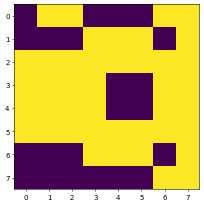

In [52]:
env.unwrapped.M.draw(obs)

In [53]:
env.args = get_args(*mbb_beam( env.unwrapped.idx_A_star, env.unwrapped.idx_Ae, env.unwrapped.TH))
t__, c__ = fast_stopt(env.args, obs)
t__

6085124.207093561

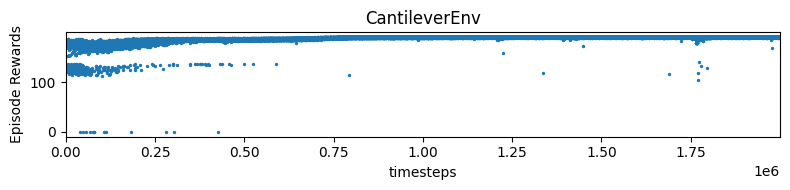

In [54]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [55]:
env.unwrapped.M.flag_=False
obs=env.reset()
obs=obs[0]

In [56]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip",env=env)

In [57]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, _,info = env.step(int(action))
    if dones:
        break
    i+=1

In [58]:
obs=obs.reshape(y0,x0)

In [59]:
for i in range(obs.shape[0]):
    for j in range(obs.shape[1]):
        if obs[i][j]==1e-04:
            obs[i][j]=0
        else:
            obs[i][j]=1

In [60]:
obs=prune_binary_matrix(obs)


Final Cantilever beam design:


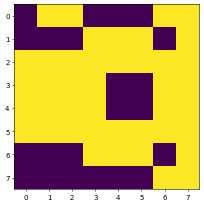

In [61]:
env.unwrapped.M.draw(obs)

In [62]:
env.args = get_args(*mbb_beam( env.unwrapped.idx_A_star, env.unwrapped.idx_Ae, env.unwrapped.TH))
t__, c__ = fast_stopt(env.args, obs)
t__

6085124.207093561

In [63]:
c__

0.6562500000000001

In [64]:
env.unwrapped.TH

163.17524232821813

In [65]:
get_sensitive_pyramid_score(obs)

0.594